In [144]:
import pandas as pd 
import numpy as np 
import pathlib as path
import matplotlib.pyplot as plt
import random
from PIL import Image
from random import sample
from cmath import nan
import json

from scipy import stats


In [145]:

batch_name='batch 3' #batch name - make sure the folder is structured as followes: (the test results/data doesnt have to be there)

#parent name: 
# -pilot_24_hours: 
#   -batch name (folder)
#       -data (folder)
#       -Batch_encoding_batch_results.csv 
#       -Batch_testing_batch_results.csv 
#       -Batch_workers.csv
#       -Batch_workers_after_test.csv


qualification_name_for_testin='UPDATE-eligible for next step memory rep'  #note that the -space- after the title is improtant as for some reason this is how the qualification name is defined
qualification_name_for_entire_experiment='UPDATE-completed memory rep'

#all data location is relational to the location of this jupiter notebook:
batch_data_location=path.Path.cwd().parent
batch_data_location = batch_data_location / 'data' / 'pilot_24_hours' 


if (batch_data_location / batch_name).is_dir():
    batch_data_location= batch_data_location / batch_name
    print('Batch found',batch_data_location)
else: 
    print(f'PROBLEM FOUND: the requested batch name {batch_name} does not apear in the folder: {batch_data_location}')


PATH_TO_DATA = batch_data_location / 'data'
if not PATH_TO_DATA.exists():
    print('There is no data folder in the requested location',batch_data_location / 'data')
else: 
    print('Data folder found',batch_data_location / 'data')




Batch found c:\Users\User\Desktop\visualpilot2\Visual-memory-task\data\pilot_24_hours\batch 3
Data folder found c:\Users\User\Desktop\visualpilot2\Visual-memory-task\data\pilot_24_hours\batch 3\data


In [146]:
#this section loads the shelf dict in the state it is after finishing the testing session for this batch. 
shelf_dict_after_test_name=batch_data_location / 'shelf after test session closed.txt' #define the name of the relevant shelf for this stage
with open(shelf_dict_after_test_name) as f:
    data = f.read()
shelf_dict = json.loads(data)
shelf_dict


{'A15B4KZ3S04HS8': [999, 1667149704730, 1667223830820, 1667239242566],
 'A1LA6CIGBNDOH9': [999, 1667156876722, 1667237966478],
 'A22HIX1M4QXZBB': [999, 1666804285762, 1666882028114],
 'A248QG4DPULP46': [999, 1666796745860, 1666875548743],
 'A2J1DNVMJ56JG1': [999, 1666806879557, 1666887012627],
 'A2J57IBR2XIWLS': [999, 1667171400527, 1667244911656, 1667248541474],
 'A3MIDLO5S7FU06': [999, 1667148924846, 1667227496622],
 'A3U0GQGAPN2DAV': [999, 1667148683750, 1667239544108],
 'A5P12YJP805RG': [999, 1667147891427, 1667216156787, 1667226130459],
 'ASNNAP90D5R1Z': [999, 1667152406322, 1667216854306, 1667237576573],
 'A1JJYY622DGE5L': [0, 1667410475964, 1667477742569],
 'A2KDZLWD8RAHDM': [999, 1667410512595],
 'AE33JO53WTHZQ': [4, 1667410525427, 1667460407566, 1667492580892],
 'A4ANRSA55IW5Q': [5, 1667410579171, 1667460858095],
 'A11EXIB1MVBZFJ': [6,
  1667410584962,
  1667481177705,
  1667481243565,
  1667486537259],
 'AMEBLCWTZKLS2': [8, 1667410598167, 1667492835383],
 'A3EBIC3PKUSKCL': [9

In [147]:
#this section reads all the relevant files: 
if (batch_data_location / 'Batch_encoding_batch_results.csv').exists():
    encoding_df=pd.read_csv(batch_data_location / 'Batch_encoding_batch_results.csv')
else: 
    print(f'no "Batch_encoding_batch_results.csv" was found in data')

if (batch_data_location / 'Batch_testing_batch_results.csv').exists():
    testing_df=pd.read_csv(batch_data_location / 'Batch_testing_batch_results.csv')
else: 
    print(f'no "Batch_testing_batch_results.csv" was found in data (probably because only the encoding session finished)')
if (batch_data_location / 'Batch_workers_after_test.csv').exists():
    workers_df=pd.read_csv(batch_data_location / 'Batch_workers_after_test.csv')
else:
    print('No AMAZON worker list was found: please make sure to upload one and name it correctly')



In [148]:
def find_largest_consequtive_repetition(responses_array):
#add a stop value so the loop will use the logic also if the end of the responses is all repeating: 
    responses_array=np.append(responses_array,[99])
    longest_rep_dict=dict()
    last_input=responses_array[0]
    consequtive_rep_counter=0
    for response in responses_array[1:]: 
        if response==last_input: #if consequtive rep: 
            consequtive_rep_counter=consequtive_rep_counter+1 #add to counter
        else: #once a new entry is in the vector - store the counter rep information 
            if last_input in longest_rep_dict.keys(): #if it was allready stored in our dictionary
                if longest_rep_dict[last_input]<consequtive_rep_counter: #replace the counter only if it is higher than what stored in dict
                    longest_rep_dict[last_input]=consequtive_rep_counter
            else: #this entry is not yet in the dictionary: add it 
                longest_rep_dict[last_input]=consequtive_rep_counter
            
            consequtive_rep_counter=0
            last_input=response
    return max(longest_rep_dict.values())

In [149]:
def process_worker_results(PATH_TO_BATCH,subject_name,parse_type='encoding'):
    cur_sub=pd.read_csv(PATH_TO_BATCH / subject_name)
    sub_demographics=cur_sub[['workID','Age','Gender']].iloc[0]

    #extract demo related information: 

    #if participant did not click on the arrow during the demo a 'demo_encoding_response.rt' colmumn wont exists: 
    #thus we will create one and fill it with nans (so everything will be consistent with other participants)
    if not('demo_encoding_response.rt' in cur_sub.columns):
        cur_sub['demo_encoding_response.rt']=np.nan
    demo_columns=['demo_encoding_loop.thisTrialN','DemoImage','DemoCorrect','demo_encoding_response.rt','demo_encoding_response.keys']

    if (parse_type=='encoding'):
        sub_demo_information=cur_sub[demo_columns]
        empty_inds=sub_demo_information.loc[sub_demo_information.isnull().apply(lambda x: all(x), axis=1)].index
        #drop irrelevant columns: 
        sub_demo_information=sub_demo_information.drop(index=empty_inds)


        #extract the demo test columns: 
        demo_test_columns=['demo_test_response.keys','demo_test_response.corr','demo_test_response.rt','demo_test_loop.thisTrialN','DemoImage1','DemoImage2','DemoCorrectTest']
        sub_demo_test_information=cur_sub[demo_test_columns]
        empty_inds=sub_demo_test_information.loc[sub_demo_test_information.isnull().apply(lambda x: all(x), axis=1)].index
        #drop irrelevant columns: 
        sub_demo_test_information=sub_demo_test_information.drop(index=empty_inds)

        demo_df=pd.concat([sub_demo_information.reset_index(),sub_demo_test_information.reset_index()],axis=1)

    #extract real experiment related information: 

    #if participant did not click on the arrow during the encoding a 'test_encoding_response.rt' column wont exists: 
    #thus we will create one and fill it with nans (so everything will be consistent with other participants)
    if not('test_encoding_response.rt' in cur_sub.columns):
        cur_sub['test_encoding_response.rt']=np.nan


    if (parse_type=='encoding') | (parse_type=='all'):
        encoding_related_columns=['test_encoding_response.keys','test_encoding_response.corr','trials.thisTrialN','target_image','pair','layer','correct','test_encoding_response.rt','key_resp_end.keys']
        sub_encoding_information=cur_sub[encoding_related_columns]
        #encoding section ends with a key press of the space key: so seperate this phase by finding this space key row
        end_of_section_ind=np.where(sub_encoding_information['key_resp_end.keys']=='space')[0][0]
        sub_encoding_information=sub_encoding_information.iloc[0:end_of_section_ind]
        #remove all the rows that precede the real encoding phase: 
        empty_inds=sub_encoding_information.loc[sub_encoding_information.isnull().apply(lambda x: all(x), axis=1)].index
        sub_encoding_information=sub_encoding_information.drop(index=empty_inds).reset_index()

    if (parse_type=='test') | (parse_type=='all'):
    #extract real experiment TEST related information: 
        test_related_columns=['layer','correct','test_test_response.keys','test_test_response.corr','test_test_response.rt','trials_2.thisRepN','trials_2.thisTrialN','trials_2.thisN','trials_2.thisIndex','trials_2.ran','image1','image2']
        sub_test_information=cur_sub[test_related_columns].dropna()


    subject_dictionary=dict()
    subject_dictionary['demographics']=sub_demographics
    if (parse_type=='encoding') | (parse_type=='all'):
        subject_dictionary['demo_df']=demo_df
    if (parse_type=='encoding') | (parse_type=='all'):
        subject_dictionary['encoding_df']=sub_encoding_information
    if (parse_type=='test') | (parse_type=='all'):
        subject_dictionary['test_df']=sub_test_information

    return subject_dictionary



In [150]:

#get all results with Encoding information - extract the arrow attention check accuracy and RT (RT is currently not usd as a criterion)

#this section extract the list of participants from the downloaded results files (and not via the workers or session list csvs) 
# - it will create the qualification_df (a table with information on the worker ids and encoding behavior of all participants that we have files for)
all_filenames=[file for file in PATH_TO_DATA.iterdir() if 'csv' in file.name and 'ENCODING' in file.name]
print(f'current csv files:\n{all_filenames}')

qualification_for_test_df=pd.DataFrame(columns=['workerID','arrow_acc','mean_arrow_RT'])
for subject_csv in all_filenames:
    subject_dict=process_worker_results(PATH_TO_DATA,path.Path(subject_csv))
    cur_sub_encoding=subject_dict['encoding_df']

    sname=subject_csv.name.split('_')[1] #change according to actuall format. 

    #get only attention check related info: 
    cur_sub_encoding=cur_sub_encoding[['test_encoding_response.keys','correct','test_encoding_response.rt']].copy().dropna(how = 'all')
    if len(cur_sub_encoding)==0: #empty - the participant didnt respond on the arrow at all
        arrow_acc=0
        RT=nan
    else: 
        RT=cur_sub_encoding['test_encoding_response.rt'].mean()
        arrow_acc=(cur_sub_encoding['correct']==cur_sub_encoding['test_encoding_response.keys']).mean()
    sub_df=pd.DataFrame({'workerID':sname,'arrow_acc':arrow_acc,'mean_arrow_RT':RT},index=[sname])
    qualification_for_test_df=pd.concat([qualification_for_test_df,sub_df],axis=0)

#the following part update the qualification_df with information on wether the participant id exists in the amazon workers list: 

#change participants qualifications if they exists in the workers list based on thier encoding arrow accuracy
qualification_for_test_df['in_encoding_workers_list']=nan

for curr_worker_ID in qualification_for_test_df.index:
    if curr_worker_ID in encoding_df['WorkerId'].values:
        qualification_for_test_df.loc[curr_worker_ID,'in_encoding_workers_list']=int(1)
    else:
        qualification_for_test_df.loc[curr_worker_ID,'in_encoding_workers_list']=int(0)


current csv files:
[WindowsPath('c:/Users/User/Desktop/visualpilot2/Visual-memory-task/data/pilot_24_hours/batch 3/data/ENCODING_A11EXIB1MVBZFJ_2022-11-02_13h36.24.962.csv'), WindowsPath('c:/Users/User/Desktop/visualpilot2/Visual-memory-task/data/pilot_24_hours/batch 3/data/ENCODING_A12K1ADYMRSWMJ_2022-11-02_18h41.13.368.csv'), WindowsPath('c:/Users/User/Desktop/visualpilot2/Visual-memory-task/data/pilot_24_hours/batch 3/data/ENCODING_A149YZJBFRDWBJ_2022-11-02_13h56.10.370.csv'), WindowsPath('c:/Users/User/Desktop/visualpilot2/Visual-memory-task/data/pilot_24_hours/batch 3/data/ENCODING_A1F9KLZGHE9DTA_2022-11-02_14h11.05.463.csv'), WindowsPath('c:/Users/User/Desktop/visualpilot2/Visual-memory-task/data/pilot_24_hours/batch 3/data/ENCODING_A1JJYY622DGE5L_2022-11-02_13h34.35.964.csv'), WindowsPath('c:/Users/User/Desktop/visualpilot2/Visual-memory-task/data/pilot_24_hours/batch 3/data/ENCODING_A1L5A88C9PPK5L_2022-11-02_10h51.22.584.csv'), WindowsPath('c:/Users/User/Desktop/visualpilot2/Vi

In [151]:
all_subjects_demo_df=pd.DataFrame()
all_subjects_encoding_df=pd.DataFrame()
all_subjects_test_df=pd.DataFrame()
all_subjects_biographics_df=pd.DataFrame()
all_filenames=[file.name for file in PATH_TO_DATA.iterdir() if 'csv' in file.name and 'TEST' in file.name]

for subject_test_filename in all_filenames:
    subject_name=subject_test_filename.split('_')[1]
    subject_encoding_filename=[file.name for file in PATH_TO_DATA.iterdir() if 'csv' in file.name and 'ENCODING' in file.name and subject_name in file.name][0]
    curr_subject_dictionary=process_worker_results(PATH_TO_DATA,subject_encoding_filename,parse_type='encoding')
    curr_demo_df=curr_subject_dictionary['demo_df']
    curr_demo_df['subject']=subject_name
    curr_encoding_df=curr_subject_dictionary['encoding_df']
    curr_encoding_df['subject']=subject_name
    curr_demographics_df=curr_subject_dictionary['demographics']
    curr_demographics_df['subject']=subject_name

    #get the name of this participant encoding: 

    curr_subject_dictionary=process_worker_results(PATH_TO_DATA,subject_test_filename,parse_type='test')
    curr_test_df=curr_subject_dictionary['test_df']
    curr_test_df['subject']=subject_name



    all_subjects_demo_df=pd.concat([all_subjects_demo_df,curr_demo_df],axis=0,ignore_index=True)
    all_subjects_encoding_df=pd.concat([all_subjects_encoding_df,curr_encoding_df],axis=0,ignore_index=True)
    all_subjects_test_df=pd.concat([all_subjects_test_df,curr_test_df],axis=0,ignore_index=True)
    all_subjects_biographics_df=pd.concat([all_subjects_biographics_df,pd.DataFrame(curr_demographics_df).T],axis=0,ignore_index=True)


all_subjects_demo_df.to_csv(PATH_TO_DATA.parent / 'all_subjects_demo_df.csv')
all_subjects_encoding_df.to_csv(PATH_TO_DATA.parent / 'all_subjects_encoding_df.csv')
all_subjects_test_df.to_csv(PATH_TO_DATA.parent / 'all_subjects_test_df.csv')
all_subjects_biographics_df.to_csv(PATH_TO_DATA.parent / 'all_subjects_biographics_df.csv')

In [152]:
from unicodedata import category

# if there are any empty values - fill with mean of subjects age 
mean_value = all_subjects_biographics_df['Age'].mean()
all_subjects_biographics_df['Age'].fillna(value=mean_value, inplace=True)
all_subjects_biographics_df['Age'] = all_subjects_biographics_df['Age'].astype(np.int64)

all_subjects_biographics_df['Age']=all_subjects_biographics_df['Age'].astype(int)
all_subjects_biographics_df['Gender'].replace({'woman':'female','FEMLAE':'female','Male':'male','MALE':'male','FEMALE':'female','Female':'female','ale':'male'},inplace=True)
if len(np.unique(all_subjects_biographics_df['Gender'].values))<=2:
    print('transformed the gender column to be consistent having two possible values:',np.unique(all_subjects_biographics_df['Gender'].values))
else: 
    print('gender is still inconsistent with more than 2 unique values:',np.unique(all_subjects_biographics_df['Gender'].values))
all_subjects_biographics_df['Gender']=all_subjects_biographics_df['Gender'].astype("category")

mean_age,min_age,max_age=all_subjects_biographics_df['Age'].mean(),all_subjects_biographics_df['Age'].min(),all_subjects_biographics_df['Age'].max()
female_prop=all_subjects_biographics_df.loc[all_subjects_biographics_df['Gender']=='female','Gender'].count()/all_subjects_biographics_df['Gender'].count()

print(f'Mean age: {mean_age:.2f}, range: [{min_age} - {max_age}], {female_prop:.2f}% female')


gender is still inconsistent with more than 2 unique values: ['Men' 'female' 'male']
Mean age: 40.13, range: [23 - 67], 0.33% female


# this part plots the seperate dataframes: 
### demo phase (encoding and test in the same dataframe)
### encoding experiment phase
### test experiment phase

In [153]:
all_subjects_demo_df.head(5)

,index,demo_encoding_loop.thisTrialN,DemoImage,DemoCorrect,demo_encoding_response.rt,demo_encoding_response.keys,index,demo_test_response.keys,demo_test_response.corr,demo_test_response.rt,demo_test_loop.thisTrialN,DemoImage1,DemoImage2,DemoCorrectTest,subject
0,4,0.0,flower1.jpg,NaN,NaN,NaN,12.0,left,1.0,28.483,0.0,flower1.jpg,flower1_pair.jpg,left,A11EXIB1MVBZFJ
1,5,1.0,flower2.jpg,NaN,NaN,NaN,13.0,right,1.0,15.897,1.0,flower2_pair.jpg,flower2.jpg,right,A11EXIB1MVBZFJ
2,6,2.0,left.jpg,left,1.156,left,14.0,left,1.0,2.285,2.0,flower3.jpg,flower3_pair.jpg,left,A11EXIB1MVBZFJ
3,7,3.0,flower3.jpg,NaN,NaN,NaN,15.0,left,1.0,2.122,3.0,flower4.jpg,flower4_pair.jpg,left,A11EXIB1MVBZFJ
4,8,4.0,flower4.jpg,NaN,NaN,NaN,16.0,right,1.0,9.966,4.0,flower5_pair.jpg,flower5.jpg,right,A11EXIB1MVBZFJ


In [154]:
all_subjects_encoding_df.head(5)

,index,test_encoding_response.keys,test_encoding_response.corr,trials.thisTrialN,target_image,pair,layer,correct,test_encoding_response.rt,key_resp_end.keys,subject
0,20,NaN,1.0,0.0,2592379964-131054.jpg,2592380272-354673.jpg,3.0,NaN,NaN,NaN,A11EXIB1MVBZFJ
1,21,NaN,1.0,1.0,2898635427-367120.jpg,2898621427-366486.jpg,3.0,NaN,NaN,NaN,A11EXIB1MVBZFJ
2,22,NaN,1.0,2.0,2458347385-199723.jpg,2458347252-348911.jpg,3.0,NaN,NaN,NaN,A11EXIB1MVBZFJ
3,23,NaN,1.0,3.0,2512875899-126682.jpg,2592380177-354628.jpg,2.0,NaN,NaN,NaN,A11EXIB1MVBZFJ
4,24,NaN,1.0,4.0,2238481928-19949.jpg,2883264367-365620.jpg,1.0,NaN,NaN,NaN,A11EXIB1MVBZFJ


In [155]:
all_subjects_test_df.head(5)

,layer,correct,test_test_response.keys,test_test_response.corr,test_test_response.rt,trials_2.thisRepN,trials_2.thisTrialN,trials_2.thisN,trials_2.thisIndex,trials_2.ran,image1,image2,subject
0,1.0,right,right,1.0,316.708,0.0,0.0,0.0,0.0,1.0,2238499057-320266.jpg,2238428357-313623.jpg,A11EXIB1MVBZFJ
1,3.0,right,left,0.0,5.956,0.0,1.0,1.0,1.0,1.0,2901941438-69835.jpg,2460547508-51571.jpg,A11EXIB1MVBZFJ
2,3.0,left,right,0.0,3.076,0.0,2.0,2.0,2.0,1.0,2238560245-182099.jpg,2238480980-168129.jpg,A11EXIB1MVBZFJ
3,1.0,right,right,1.0,1.610,0.0,3.0,3.0,3.0,1.0,2864901420-212147.jpg,2864907432-362042.jpg,A11EXIB1MVBZFJ
4,1.0,right,right,1.0,1.676,0.0,4.0,4.0,4.0,1.0,2446759803-49250.jpg,2898635428-69104.jpg,A11EXIB1MVBZFJ


In [156]:
#this section extract information from the demo phase: it creates a df (all_subjects_summary_demo_info) containingsingle row per participants with metrics from the demo phase (average accuracy, RTs and so on (this can be used to screen participatns for further analysis)):
all_subjects_summary_demo_info=pd.DataFrame(index=list(all_subjects_demo_df['subject'].unique()))

for cur_subject in all_subjects_demo_df['subject'].unique():
    cur_sub_demo_encoding=all_subjects_demo_df.loc[all_subjects_demo_df['subject']==cur_subject]
    
    #get only attention check related info: 
    curr_subjects_summary_demo_info=cur_sub_demo_encoding[['demo_encoding_response.keys','DemoCorrect','demo_encoding_response.rt']].copy().dropna()
    if len(curr_subjects_summary_demo_info)==0: #empty - the participant didnt respond on the arrow at all: 
       all_subjects_summary_demo_info.loc[cur_subject,'arrow_correct']=0 
       all_subjects_summary_demo_info.loc[cur_subject,'arrow_rt']=np.nan
    else: 
        all_subjects_summary_demo_info.loc[cur_subject,'arrow_rt']=curr_subjects_summary_demo_info['demo_encoding_response.rt'].values
        if all(curr_subjects_summary_demo_info['DemoCorrect']==curr_subjects_summary_demo_info['demo_encoding_response.keys']):
            all_subjects_summary_demo_info.loc[cur_subject,'arrow_correct']=1
        else:
            all_subjects_summary_demo_info.loc[cur_subject,'arrow_correct']=0


    #get the correctness of the demo testing phase: 
    cur_sub_demo_test_performence=cur_sub_demo_encoding[['DemoCorrectTest','demo_test_response.keys','demo_test_response.rt']].copy().dropna()
    test_match_df=pd.DataFrame(columns=['arrow_correct'],data=cur_sub_demo_test_performence['DemoCorrectTest']==cur_sub_demo_test_performence['demo_test_response.keys'])
    test_match_df['demo_test_response.rt']=cur_sub_demo_test_performence['demo_test_response.rt']
    accuracy=test_match_df['arrow_correct'].mean()
    mean_rt=test_match_df['demo_test_response.rt'].mean()
    correct_and_incorrect_rts=test_match_df.groupby('arrow_correct').aggregate({'demo_test_response.rt':'mean'})
    #update the summary info row: 
    all_subjects_summary_demo_info.loc[cur_subject,'demo_accuracy']=accuracy
    all_subjects_summary_demo_info.loc[cur_subject,'RT_overall_mean']=mean_rt
    all_subjects_summary_demo_info.loc[cur_subject,['RT_incorrect_mean','RT_correct_mean']]=np.nan

    if False in correct_and_incorrect_rts.index:
        all_subjects_summary_demo_info.loc[cur_subject,'RT_incorrect_mean']=correct_and_incorrect_rts.loc[False].values[0]
    if True in correct_and_incorrect_rts.index:
        all_subjects_summary_demo_info.loc[cur_subject,'RT_correct_mean']=correct_and_incorrect_rts.loc[True].values[0]


#add a prefix to column names: 
all_subjects_summary_demo_info.columns=['demo_'+col for col in all_subjects_summary_demo_info.columns]
all_subjects_summary_demo_info

,demo_arrow_rt,demo_arrow_correct,demo_demo_accuracy,demo_RT_overall_mean,demo_RT_incorrect_mean,demo_RT_correct_mean
A11EXIB1MVBZFJ,1.1560,1.0,1.000000,15.790667,NaN,15.790667
A1F9KLZGHE9DTA,0.5979,1.0,0.833333,1.385950,1.740400,1.315060
A1LCUPRZ0I8S3I,0.9871,1.0,1.000000,2.185933,NaN,2.185933
A1OOCYEFLAJD98,0.5116,1.0,1.000000,2.427583,NaN,2.427583
A1U0FDPQ953KXX,1.1286,1.0,0.833333,5.252667,3.311800,5.640840
A2ASRB2MTHDHPD,1.2799,1.0,0.500000,5.293650,4.709733,5.877567
A2M183CETUMR96,0.5185,1.0,0.333333,5.864933,3.148550,11.297700
A3JJXDML3XNSQP,1.8620,1.0,0.833333,5.357000,15.925000,3.243400
A3RDT5DH21PVAR,2.1221,1.0,0.666667,2.208033,1.722100,2.451000
A3VHDQR8A9JJ4F,0.6487,1.0,0.833333,1.888650,1.807700,1.904840


In [157]:
#this part extract summary information from the experiment encoding phase: attention check accuracy and timings: 
all_subjects_summary_encoding_info=pd.DataFrame(index=list(all_subjects_encoding_df['subject'].unique()))

for cur_subject in all_subjects_encoding_df['subject'].unique():
    cur_sub_encoding=all_subjects_encoding_df.loc[all_subjects_encoding_df['subject']==cur_subject]
    
    #get only attention check related info: 
    cur_sub_encoding=cur_sub_encoding[['test_encoding_response.keys','correct','test_encoding_response.rt']].copy().dropna(how = 'all')
    if len(cur_sub_encoding)==0: #empty - the participant didnt respond on the arrow at all: 
       all_subjects_summary_encoding_info.loc[cur_subject,'arrow_accuracy']=0 
       all_subjects_summary_encoding_info.loc[cur_subject,'arrow_mean_rt']=np.nan
    else: 
        all_subjects_summary_encoding_info.loc[cur_subject,'arrow_mean_rt']=cur_sub_encoding['test_encoding_response.rt'].mean()
        arrow_accuracy=(cur_sub_encoding['correct']==cur_sub_encoding['test_encoding_response.keys']).mean()
        all_subjects_summary_encoding_info.loc[cur_subject,'arrow_accuracy']=arrow_accuracy



#add a prefix to column names: 
all_subjects_summary_encoding_info.columns=['encoding_'+col for col in all_subjects_summary_encoding_info.columns]        
all_subjects_summary_encoding_info

,encoding_arrow_mean_rt,encoding_arrow_accuracy
A11EXIB1MVBZFJ,1.13860,1.0
A1F9KLZGHE9DTA,0.59792,1.0
A1LCUPRZ0I8S3I,1.37952,1.0
A1OOCYEFLAJD98,0.67562,1.0
A1U0FDPQ953KXX,1.30840,1.0
A2ASRB2MTHDHPD,1.63130,1.0
A2M183CETUMR96,0.48240,1.0
A3JJXDML3XNSQP,1.37120,1.0
A3RDT5DH21PVAR,1.14476,0.8
A3VHDQR8A9JJ4F,0.62064,1.0


In [158]:
#this part extract summary information from the experiment testing phase: attention check accuracy and timings: 
all_subjects_summary_testing_info=pd.DataFrame(index=list(all_subjects_test_df['subject'].unique()))


#this code calculates response time averages (RT) exlcusing the trials that are TOO long: 
trial_too_long_exclusion_criteria=10


for cur_subject in all_subjects_test_df['subject'].unique():
    cur_sub_testing=all_subjects_test_df.loc[all_subjects_test_df['subject']==cur_subject]

    #get the correctness of the testing phase: 
    cur_sub_testing_performence=cur_sub_testing[['correct','test_test_response.keys','test_test_response.rt','layer','test_test_response.corr']].copy().dropna()


    test_match_df=pd.DataFrame(columns=['correct'],data=cur_sub_testing_performence['correct']==cur_sub_testing_performence['test_test_response.keys'])
    test_match_df['test_test_response.rt']=cur_sub_testing_performence['test_test_response.rt']
    accuracy=test_match_df['correct'].mean()

    # if there is one rt that is very long, lets not include it in the mean calculation 
    
    mean_rt=(test_match_df.loc[test_match_df['test_test_response.rt']<=trial_too_long_exclusion_criteria,'test_test_response.rt']).mean()
    correct_and_incorrect_rts_overall=test_match_df.groupby('correct').aggregate({'test_test_response.rt':'mean'})
    
    #update the summary info row: 
    all_subjects_summary_testing_info.loc[cur_subject,'Test_overall_accuracy']=accuracy
    all_subjects_summary_testing_info.loc[cur_subject,'RT_overall_mean']=mean_rt
    all_subjects_summary_testing_info.loc[cur_subject,['RT_incorrect_mean','RT_correct_mean']]=np.nan

    if False in correct_and_incorrect_rts_overall.index:
        all_subjects_summary_testing_info.loc[cur_subject,'RT_incorrect_mean']=correct_and_incorrect_rts_overall.loc[False].values[0]
    if True in correct_and_incorrect_rts_overall.index:
        all_subjects_summary_testing_info.loc[cur_subject,'RT_correct_mean']=correct_and_incorrect_rts_overall.loc[True].values[0]



    #extract layer wise information (accuracy and rt):
    cur_sub_testing_performence_copy=cur_sub_testing_performence.copy()
    cur_sub_testing_performence_copy.loc[cur_sub_testing_performence_copy['test_test_response.rt']>trial_too_long_exclusion_criteria,'test_test_response.rt']=nan
    correct_and_incorrect_rts=cur_sub_testing_performence_copy.groupby('layer').aggregate({'test_test_response.rt':'mean','test_test_response.corr':'mean'})
    all_subjects_summary_testing_info.loc[cur_subject,['layer_1_rt','layer_1_accuracy','layer_2_rt','layer_2_accuracy','layer_3_rt','layer_3_accuracy']]=correct_and_incorrect_rts.values.flatten()


    #check the longest structured strike (to find bots or very unattentive participants):
    responses=cur_sub_testing_performence['test_test_response.keys'].replace({'left':1,'right':2}).values
    max_iter=find_largest_consequtive_repetition(responses)

    all_subjects_summary_testing_info.loc[cur_subject,'longest_response_strike']=max_iter

#add a prefix to column names: 
all_subjects_summary_testing_info.columns=['testing_'+col for col in all_subjects_summary_testing_info.columns]        
all_subjects_summary_testing_info

,testing_Test_overall_accuracy,testing_RT_overall_mean,testing_RT_incorrect_mean,testing_RT_correct_mean,testing_layer_1_rt,testing_layer_1_accuracy,testing_layer_2_rt,testing_layer_2_accuracy,testing_layer_3_rt,testing_layer_3_accuracy,testing_longest_response_strike
A11EXIB1MVBZFJ,0.516667,2.094241,3.899862,12.155968,2.203368,0.60,1.671950,0.50,2.429632,0.45,4.0
A1F9KLZGHE9DTA,0.566667,1.418513,1.469431,1.379576,1.499780,0.65,1.293545,0.60,1.462215,0.45,6.0
A1LCUPRZ0I8S3I,0.633333,2.649913,2.984377,2.456276,2.447855,0.75,2.726375,0.50,2.775510,0.65,4.0
A1OOCYEFLAJD98,0.683333,2.343953,2.364995,4.215473,2.133665,0.75,2.373321,0.70,2.526340,0.60,4.0
A1U0FDPQ953KXX,0.683333,2.785461,2.953126,3.233671,2.932160,0.75,3.165090,0.60,2.231432,0.70,3.0
A2ASRB2MTHDHPD,0.500000,1.991117,3.284967,1.759483,2.114545,0.70,1.728868,0.25,2.116825,0.55,9.0
A2M183CETUMR96,0.900000,3.089463,3.843117,3.468331,2.946050,0.90,2.996610,0.90,3.323068,0.90,5.0
A3JJXDML3XNSQP,0.450000,3.407035,3.755030,6.430444,3.214316,0.30,3.324833,0.45,3.664100,0.60,3.0
A3RDT5DH21PVAR,0.416667,1.398958,1.180700,1.704520,1.312745,0.50,1.234080,0.35,1.650050,0.40,4.0
A3VHDQR8A9JJ4F,0.583333,1.261107,1.207860,1.299140,1.261695,0.60,1.359075,0.70,1.162550,0.45,7.0


In [159]:
cur_sub_testing_performence.loc[cur_sub_testing_performence['test_test_response.rt']>trial_too_long_exclusion_criteria,'test_test_response.rt']=nan
cur_sub_testing_performence

,correct,test_test_response.keys,test_test_response.rt,layer,test_test_response.corr
840,left,right,2.8954,1.0,0.0
841,left,left,1.8464,3.0,1.0
842,right,right,1.8510,3.0,1.0
843,right,right,1.6270,3.0,1.0
844,left,left,1.9200,2.0,1.0
845,left,left,1.4969,2.0,1.0
846,left,left,1.4957,1.0,1.0
847,right,left,2.8855,3.0,0.0
848,right,left,3.1462,3.0,0.0
849,left,left,1.3710,1.0,1.0


In [160]:
mean_rt

2.5476733333333335

In [161]:
def find_outlier_responses(sub_test_dataframe,fast_threshold=0.1,fast_allowed_count=2,slow_threshold=10,slow_allowed_count=2):
    isfast_outlier=(sub_test_dataframe['test_test_response.rt']<fast_threshold).sum()>fast_allowed_count
    isslow_outlier=(sub_test_dataframe['test_test_response.rt']>slow_threshold).sum()>slow_allowed_count
    return isfast_outlier,isslow_outlier

In [162]:
#combine all oneliners into a single matrix - 1 line per participant with all information we want:
data_df_for_analysis=pd.concat([all_subjects_summary_demo_info,all_subjects_summary_encoding_info,all_subjects_summary_testing_info],axis=1)
data_df_for_analysis


#define thresholds: 
demo_accuracy_treshold=0.5
demo_arrow_correctness=1
encoding_arrow_accuracy=0.6
longest_allowed_consequtive_strike=15
fast_threshold=0.3
fast_allowed_count=3
slow_threshold=10
slow_allowed_count=2


#as each participant saw 20 distractors per layer, we need atleast 0.75 (15/20) accuracy in one of the layers or above 0.616 (37/60) in the overall: 



#how many participants would fail the demo (did not correctly answered the arrow or had less than 60% performence)
demo_criterions_accuracy=data_df_for_analysis['demo_demo_accuracy']>=demo_accuracy_treshold
demo_criterions_attention_check=data_df_for_analysis['demo_arrow_correct']>=demo_arrow_correctness
#find which participants performed pooly on the attention checks of the experiment encoding phase: 
encoding_ciriterions=data_df_for_analysis['encoding_arrow_accuracy']>encoding_arrow_accuracy
#remove participants that are too slow: 
test_criterions_strike=data_df_for_analysis['testing_longest_response_strike']<longest_allowed_consequtive_strike

too_fast_criterions=[]
too_slow_criterions=[]
for subject in data_df_for_analysis.index:
    sub_test_dataframe=all_subjects_test_df[all_subjects_test_df['subject']==subject]
    toofast_criterion,tooslow_criterion=find_outlier_responses(sub_test_dataframe,fast_threshold=fast_threshold,fast_allowed_count=fast_allowed_count,slow_threshold=slow_threshold,slow_allowed_count=slow_allowed_count)
    too_slow_criterions.append(not tooslow_criterion)
    too_fast_criterions.append(not toofast_criterion)



print(f'summary for criterions:')
print(f'demo accuracy higher than {demo_accuracy_treshold} - qualified: {demo_criterions_accuracy.sum()}')
print(f'demo attention check correctness equals {demo_arrow_correctness} - qualified: {demo_criterions_attention_check.sum()}')
print(f'experiment encoding attention check accuracy {encoding_arrow_accuracy} - qualified: {encoding_ciriterions.sum()}')
print(f'experiment longest consequtive strike of maximum of  {longest_allowed_consequtive_strike} responses - qualified: {test_criterions_strike.sum()}')
print(f'test too fast (thresold: {fast_threshold}, allowed count: {fast_allowed_count} qualified: {sum(too_fast_criterions)}')
print(f'test too slow (thresold: {slow_threshold}, allowed count: {slow_allowed_count} qualified: {sum(too_slow_criterions)}')
#accuracy criterion on the test: 
test_accuracy_critertions=(data_df_for_analysis['testing_Test_overall_accuracy']>=0.61) | (data_df_for_analysis[['testing_layer_1_accuracy' ,'testing_layer_2_accuracy' ,'testing_layer_3_accuracy']]>=0.75).T.any()
#remove participants that were discarded based on behavior up to the test and now qualify or disqualify based on test accuracy (do they have atleast 1 significant (binomial test) accuracy in one layer, or above threshold in overall accuracy )
only_qualified=demo_criterions_accuracy & demo_criterions_attention_check & encoding_ciriterions & test_criterions_strike & too_fast_criterions & too_slow_criterions & test_accuracy_critertions
print(f'above chance accuracy in test, qualified: {sum(test_accuracy_critertions)}')
print(f'OVERALL: number of qualified participants (adhere to all criterions): {sum(only_qualified)}')


summary for criterions:
demo accuracy higher than 0.5 - qualified: 14
demo attention check correctness equals 1 - qualified: 15
experiment encoding attention check accuracy 0.6 - qualified: 14
experiment longest consequtive strike of maximum of  15 responses - qualified: 15
test too fast (thresold: 0.3, allowed count: 3 qualified: 15
test too slow (thresold: 10, allowed count: 2 qualified: 13
above chance accuracy in test, qualified: 8
OVERALL: number of qualified participants (adhere to all criterions): 6


In [163]:
data_df_for_analysis

,demo_arrow_rt,demo_arrow_correct,demo_demo_accuracy,demo_RT_overall_mean,demo_RT_incorrect_mean,demo_RT_correct_mean,encoding_arrow_mean_rt,encoding_arrow_accuracy,testing_Test_overall_accuracy,testing_RT_overall_mean,testing_RT_incorrect_mean,testing_RT_correct_mean,testing_layer_1_rt,testing_layer_1_accuracy,testing_layer_2_rt,testing_layer_2_accuracy,testing_layer_3_rt,testing_layer_3_accuracy,testing_longest_response_strike
A11EXIB1MVBZFJ,1.1560,1.0,1.000000,15.790667,NaN,15.790667,1.13860,1.0,0.516667,2.094241,3.899862,12.155968,2.203368,0.60,1.671950,0.50,2.429632,0.45,4.0
A1F9KLZGHE9DTA,0.5979,1.0,0.833333,1.385950,1.740400,1.315060,0.59792,1.0,0.566667,1.418513,1.469431,1.379576,1.499780,0.65,1.293545,0.60,1.462215,0.45,6.0
A1LCUPRZ0I8S3I,0.9871,1.0,1.000000,2.185933,NaN,2.185933,1.37952,1.0,0.633333,2.649913,2.984377,2.456276,2.447855,0.75,2.726375,0.50,2.775510,0.65,4.0
A1OOCYEFLAJD98,0.5116,1.0,1.000000,2.427583,NaN,2.427583,0.67562,1.0,0.683333,2.343953,2.364995,4.215473,2.133665,0.75,2.373321,0.70,2.526340,0.60,4.0
A1U0FDPQ953KXX,1.1286,1.0,0.833333,5.252667,3.311800,5.640840,1.30840,1.0,0.683333,2.785461,2.953126,3.233671,2.932160,0.75,3.165090,0.60,2.231432,0.70,3.0
A2ASRB2MTHDHPD,1.2799,1.0,0.500000,5.293650,4.709733,5.877567,1.63130,1.0,0.500000,1.991117,3.284967,1.759483,2.114545,0.70,1.728868,0.25,2.116825,0.55,9.0
A2M183CETUMR96,0.5185,1.0,0.333333,5.864933,3.148550,11.297700,0.48240,1.0,0.900000,3.089463,3.843117,3.468331,2.946050,0.90,2.996610,0.90,3.323068,0.90,5.0
A3JJXDML3XNSQP,1.8620,1.0,0.833333,5.357000,15.925000,3.243400,1.37120,1.0,0.450000,3.407035,3.755030,6.430444,3.214316,0.30,3.324833,0.45,3.664100,0.60,3.0
A3RDT5DH21PVAR,2.1221,1.0,0.666667,2.208033,1.722100,2.451000,1.14476,0.8,0.416667,1.398958,1.180700,1.704520,1.312745,0.50,1.234080,0.35,1.650050,0.40,4.0
A3VHDQR8A9JJ4F,0.6487,1.0,0.833333,1.888650,1.807700,1.904840,0.62064,1.0,0.583333,1.261107,1.207860,1.299140,1.261695,0.60,1.359075,0.70,1.162550,0.45,7.0


In [164]:
#update the batch_workers_df  with columns representing disqualification reasons: 
tooslow_df=pd.DataFrame(data=too_slow_criterions,index=data_df_for_analysis.index,columns=['not_too_slow'])
toofast_df=pd.DataFrame(data=too_fast_criterions,index=data_df_for_analysis.index,columns=['not_too_Fast'])
test_accuracy_critertions=pd.DataFrame(data=test_accuracy_critertions,index=data_df_for_analysis.index, columns=['sufficient_test_acc'])
disqualification_df=pd.concat([demo_criterions_accuracy,demo_criterions_attention_check,encoding_ciriterions,test_criterions_strike,tooslow_df,toofast_df,test_accuracy_critertions],axis=1)
disqualification_df


,demo_demo_accuracy,demo_arrow_correct,encoding_arrow_accuracy,testing_longest_response_strike,not_too_slow,not_too_Fast,sufficient_test_acc
A11EXIB1MVBZFJ,True,True,True,True,True,True,False
A1F9KLZGHE9DTA,True,True,True,True,True,True,False
A1LCUPRZ0I8S3I,True,True,True,True,True,True,True
A1OOCYEFLAJD98,True,True,True,True,True,True,True
A1U0FDPQ953KXX,True,True,True,True,True,True,True
A2ASRB2MTHDHPD,True,True,True,True,True,True,False
A2M183CETUMR96,False,True,True,True,False,True,True
A3JJXDML3XNSQP,True,True,True,True,False,True,False
A3RDT5DH21PVAR,True,True,True,True,True,True,False
A3VHDQR8A9JJ4F,True,True,True,True,True,True,False


In [165]:
#merge workers_df with disqualification and save: 
index_list=[ind.split('_')[0] for ind in disqualification_df.index]
disqualification_df['WorkerId']=index_list

batch_workers_df_extended = workers_df.merge(disqualification_df, left_on='Worker ID', right_on='WorkerId', how = 'inner')
batch_workers_df_extended = workers_df.merge(disqualification_df, left_on='Worker ID', right_on='WorkerId', how = 'outer')

#add qualification column: (currently any participant will get this qualification (even if he just openneded the experiment and quit, because we dont want him back)
qualification_colname='UPDATE-completed memory rep'
batch_workers_df_extended[qualification_colname]=1



In [166]:
#extract data that passes all criterions: 
final_participants_df=data_df_for_analysis[only_qualified]
final_participants_df

,demo_arrow_rt,demo_arrow_correct,demo_demo_accuracy,demo_RT_overall_mean,demo_RT_incorrect_mean,demo_RT_correct_mean,encoding_arrow_mean_rt,encoding_arrow_accuracy,testing_Test_overall_accuracy,testing_RT_overall_mean,testing_RT_incorrect_mean,testing_RT_correct_mean,testing_layer_1_rt,testing_layer_1_accuracy,testing_layer_2_rt,testing_layer_2_accuracy,testing_layer_3_rt,testing_layer_3_accuracy,testing_longest_response_strike
A1LCUPRZ0I8S3I,0.9871,1.0,1.000000,2.185933,NaN,2.185933,1.37952,1.0,0.633333,2.649913,2.984377,2.456276,2.447855,0.75,2.726375,0.50,2.775510,0.65,4.0
A1OOCYEFLAJD98,0.5116,1.0,1.000000,2.427583,NaN,2.427583,0.67562,1.0,0.683333,2.343953,2.364995,4.215473,2.133665,0.75,2.373321,0.70,2.526340,0.60,4.0
A1U0FDPQ953KXX,1.1286,1.0,0.833333,5.252667,3.3118,5.640840,1.30840,1.0,0.683333,2.785461,2.953126,3.233671,2.932160,0.75,3.165090,0.60,2.231432,0.70,3.0
AK4WAT44YKU7J,0.6394,1.0,0.666667,2.239683,2.5745,2.072275,0.52266,1.0,0.783333,2.428318,2.267331,2.472847,2.452395,0.70,2.254125,0.85,2.578435,0.80,7.0
AMEBLCWTZKLS2,0.9730,1.0,0.833333,1.663333,1.3950,1.717000,1.03720,1.0,0.583333,2.287683,2.439800,2.179029,2.148400,0.75,2.409650,0.55,2.305000,0.45,3.0
ATA61WNUAP91U,1.3853,1.0,0.833333,2.389683,2.1828,2.431060,1.27288,1.0,0.650000,2.547673,2.430700,2.610659,2.755065,0.80,2.373785,0.65,2.514170,0.50,5.0


In [167]:
total_data = pd.concat([data_df_for_analysis,disqualification_df], axis = 1)
total_data.head()

,demo_arrow_rt,demo_arrow_correct,demo_demo_accuracy,demo_RT_overall_mean,demo_RT_incorrect_mean,demo_RT_correct_mean,encoding_arrow_mean_rt,encoding_arrow_accuracy,testing_Test_overall_accuracy,testing_RT_overall_mean,...,testing_layer_3_accuracy,testing_longest_response_strike,demo_demo_accuracy,demo_arrow_correct,encoding_arrow_accuracy,testing_longest_response_strike,not_too_slow,not_too_Fast,sufficient_test_acc,WorkerId
A11EXIB1MVBZFJ,1.1560,1.0,1.000000,15.790667,NaN,15.790667,1.13860,1.0,0.516667,2.094241,...,0.45,4.0,True,True,True,True,True,True,False,A11EXIB1MVBZFJ
A1F9KLZGHE9DTA,0.5979,1.0,0.833333,1.385950,1.7404,1.315060,0.59792,1.0,0.566667,1.418513,...,0.45,6.0,True,True,True,True,True,True,False,A1F9KLZGHE9DTA
A1LCUPRZ0I8S3I,0.9871,1.0,1.000000,2.185933,NaN,2.185933,1.37952,1.0,0.633333,2.649913,...,0.65,4.0,True,True,True,True,True,True,True,A1LCUPRZ0I8S3I
A1OOCYEFLAJD98,0.5116,1.0,1.000000,2.427583,NaN,2.427583,0.67562,1.0,0.683333,2.343953,...,0.60,4.0,True,True,True,True,True,True,True,A1OOCYEFLAJD98
A1U0FDPQ953KXX,1.1286,1.0,0.833333,5.252667,3.3118,5.640840,1.30840,1.0,0.683333,2.785461,...,0.70,3.0,True,True,True,True,True,True,True,A1U0FDPQ953KXX


In [168]:
#save the final_participants_df and the data_df_for_analysis to disk: 
final_participants_df.to_csv(PATH_TO_DATA.parent / 'one_line_per_participant_all_info_valid_subjects_only.csv')
total_data.to_csv(PATH_TO_DATA.parent / 'one_line_per_participant_all_info_all_subject.csv')

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:k'` for same effect.
  warnings.warn(msg, FutureWarning)
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:k'` for same effect.
  warnings.warn(msg, FutureWarning)


Text(510.4494949494949, 0.5, 'RT')

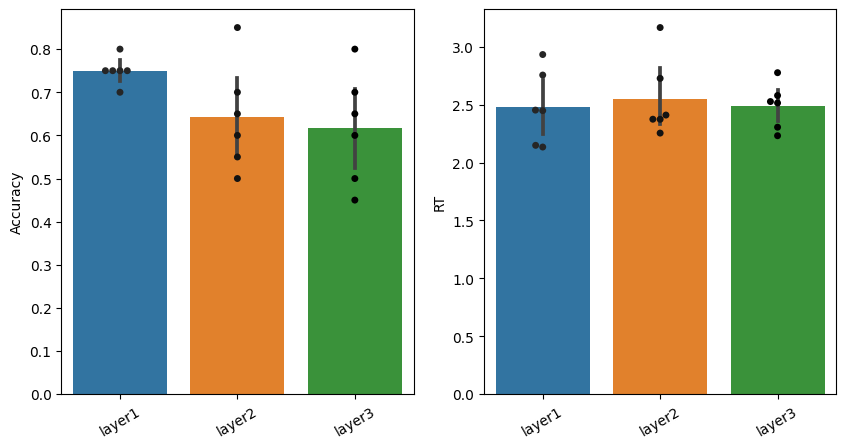

In [169]:
import seaborn as sns

fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(10,5))
sns.barplot(data=final_participants_df[['testing_layer_1_accuracy','testing_layer_2_accuracy','testing_layer_3_accuracy']],ax=axes[0])
sns.swarmplot(data=final_participants_df[['testing_layer_1_accuracy','testing_layer_2_accuracy','testing_layer_3_accuracy']],ax=axes[0],color='k')

axes[0].set_xticklabels(labels=['layer1','layer2','layer3'],rotation=30)
axes[0].set_ylabel('Accuracy')

sns.barplot(data=final_participants_df[['testing_layer_1_rt','testing_layer_2_rt','testing_layer_3_rt']],ax=axes[1])
sns.swarmplot(data=final_participants_df[['testing_layer_1_rt','testing_layer_2_rt','testing_layer_3_rt']],ax=axes[1],color='k')

axes[1].set_xticklabels(labels=['layer1','layer2','layer3'],rotation=30)
axes[1].set_ylabel('RT')


Text(0, 0.5, 'RT')

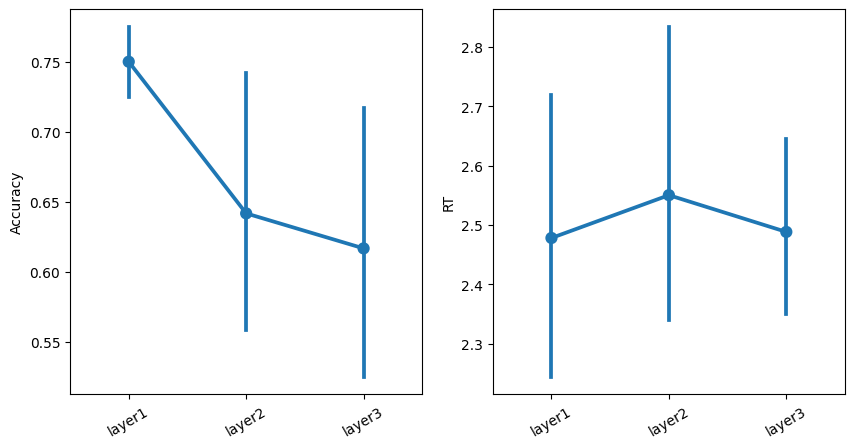

In [170]:
import seaborn as sns

fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(10,5))
sns.pointplot(data=final_participants_df[['testing_layer_1_accuracy','testing_layer_2_accuracy','testing_layer_3_accuracy']],ax=axes[0])
#sns.swarmplot(data=final_participants_df[['testing_layer_1_accuracy','testing_layer_2_accuracy','testing_layer_3_accuracy']],ax=axes[0],color='k')

axes[0].set_xticklabels(labels=['layer1','layer2','layer3'],rotation=30)
axes[0].set_ylabel('Accuracy')

sns.pointplot(data=final_participants_df[['testing_layer_1_rt','testing_layer_2_rt','testing_layer_3_rt']],ax=axes[1])
#sns.swarmplot(data=final_participants_df[['testing_layer_1_rt','testing_layer_2_rt','testing_layer_3_rt']],ax=axes[1],color='k')

axes[1].set_xticklabels(labels=['layer1','layer2','layer3'],rotation=30)
axes[1].set_ylabel('RT')


In [171]:
#this is the updated shelf: copy from here and place in the shelf location in pavlovia.org
new_shelf_dict=shelf_dict.copy()


clean_shelf_after_test=True #change to true if you run this code after completing both encoding and test sessions and want to also resert participants that didnt come back at all... 
if clean_shelf_after_test: 


    allowed_interval_in_hours=24
    allowed_jitter=3
    allowed_interval_in_ms=[allowed_interval_in_hours-allowed_jitter,allowed_interval_in_hours+allowed_jitter]*3600*1000


    new_shelf_dict=shelf_dict.copy()
    changed_keys_list=[]
    for key in new_shelf_dict.keys():
        cur_entries=new_shelf_dict[key]
        if len(cur_entries)==2: 
            cur_entries[0]=999
            changed_keys_list.append(key)

        if len(cur_entries)>2:
            encoding_time=cur_entries[1]
            last_entree=cur_entries[-1]
            if (last_entree - encoding_time) < allowed_interval_in_ms[0]:
                cur_entries[0]=999
                changed_keys_list.append(key)


        new_shelf_dict[key]=cur_entries

    print('changed entrees for:',changed_keys_list)

    ##### print the updated shelf dictionary so you can copy it from the cell output and paste in the shelf:  (change the shelf only if you run this code after both encoding and TEST has ended) ####
    new_shelf_dict


changed entrees for: ['A2KDZLWD8RAHDM', 'A3EBIC3PKUSKCL', 'A1PN0EFQD8OHSU', 'A10AKR84P1WXHL', 'A1MT4FMXL4WRAF', 'ABGKJYEITBKIL', 'AL113DDABUJQ0', 'A1CB9NR3SN4VMY', 'A2HY7GQ07YIZTT', 'A1W0K28IND6NR4', 'A2U50SMRZT60ZF', 'A3UZ5V4Y0K3YPV', 'AEHH65WR5E3L6', 'A1SL80AWG592HX', 'A1I1IMZ2ROJY3I', 'A3NME80IO3UFFO', 'A2PTABUVOUYAH5', 'A3USIO03UXTDUT', 'AVP8OEUW3NB4D', 'A1HUQ7QA5QWM5Q', 'A2F5SKVBQQXFX0', 'A3FJQY40AAYLDF', 'A12K1ADYMRSWMJ', 'A1W9HGZ8IKQMTW', 'A5AE8MWFQVBX62', 'ASQJWS2HM0ZW9', 'A5JWBZ2885D1N', 'A14CZ7WXO9TOSX', 'AEOLA4FY5IDHE', 'A2Y8LZS5C81O25', 'AQC0KPAOX4ZPL', 'A3NAONPCTVT6P1', 'A2PF6UAA5SUVD0', 'A290Z6QAL17PQE', 'A2MQPQ30Z0ETL4', 'AG6UL22QLCKOG', 'A29DB0P3TCTY3I', 'A1Y0ZBE9UBJV2S', 'A3Q228ENXTJ38F', 'A1NQVG69U3TRDK', 'A39IAY6VBVR8FD', 'A3JRY3AL756S3P', 'AP9YNGPNQSX7I', 'A29O6FOYRB10S2', 'AUGML2ZY46M47', 'A2HFHW1AT6CYCV', 'A2A66Wjgsvjmdcmc', 'A2BUHMLNE3LUU1']


In [172]:
final_participants_df

,demo_arrow_rt,demo_arrow_correct,demo_demo_accuracy,demo_RT_overall_mean,demo_RT_incorrect_mean,demo_RT_correct_mean,encoding_arrow_mean_rt,encoding_arrow_accuracy,testing_Test_overall_accuracy,testing_RT_overall_mean,testing_RT_incorrect_mean,testing_RT_correct_mean,testing_layer_1_rt,testing_layer_1_accuracy,testing_layer_2_rt,testing_layer_2_accuracy,testing_layer_3_rt,testing_layer_3_accuracy,testing_longest_response_strike
A1LCUPRZ0I8S3I,0.9871,1.0,1.000000,2.185933,NaN,2.185933,1.37952,1.0,0.633333,2.649913,2.984377,2.456276,2.447855,0.75,2.726375,0.50,2.775510,0.65,4.0
A1OOCYEFLAJD98,0.5116,1.0,1.000000,2.427583,NaN,2.427583,0.67562,1.0,0.683333,2.343953,2.364995,4.215473,2.133665,0.75,2.373321,0.70,2.526340,0.60,4.0
A1U0FDPQ953KXX,1.1286,1.0,0.833333,5.252667,3.3118,5.640840,1.30840,1.0,0.683333,2.785461,2.953126,3.233671,2.932160,0.75,3.165090,0.60,2.231432,0.70,3.0
AK4WAT44YKU7J,0.6394,1.0,0.666667,2.239683,2.5745,2.072275,0.52266,1.0,0.783333,2.428318,2.267331,2.472847,2.452395,0.70,2.254125,0.85,2.578435,0.80,7.0
AMEBLCWTZKLS2,0.9730,1.0,0.833333,1.663333,1.3950,1.717000,1.03720,1.0,0.583333,2.287683,2.439800,2.179029,2.148400,0.75,2.409650,0.55,2.305000,0.45,3.0
ATA61WNUAP91U,1.3853,1.0,0.833333,2.389683,2.1828,2.431060,1.27288,1.0,0.650000,2.547673,2.430700,2.610659,2.755065,0.80,2.373785,0.65,2.514170,0.50,5.0


In [173]:
#find all participants that exists in the shelf, and make sure they have a participantion code (so they wont be able to come back to this experiemnt)
all_shelf_workers_that_are_assigned_participantion=[]
for curr_key in shelf_dict.keys():
    if curr_key in workers_df['Worker ID'].values:
        workers_df.loc[workers_df['Worker ID']==curr_key,qualification_name_for_entire_experiment]=1
        all_shelf_workers_that_are_assigned_participantion.append(curr_key)

print(f'{len(all_shelf_workers_that_are_assigned_participantion)} were given a {qualification_name_for_entire_experiment}, names: {all_shelf_workers_that_are_assigned_participantion}')

#create a new shelf, that only contains the ids and numbers of valid participants (this is so we wont re-use thier custom trials order (csvs))
new_shelf_dict=dict()
for sub_id in final_participants_df.index: 
    new_shelf_dict[sub_id]=shelf_dict[sub_id]
new_shelf_dict  

print('\n\ncompy the following dictionary content to the pavlovia dictionary, and to the "shelf final state.txt"\n')
json.dumps(new_shelf_dict)

48 were given a UPDATE-completed memory rep, names: ['A15B4KZ3S04HS8', 'A1LA6CIGBNDOH9', 'A22HIX1M4QXZBB', 'A248QG4DPULP46', 'A2J1DNVMJ56JG1', 'A2J57IBR2XIWLS', 'A3MIDLO5S7FU06', 'A3U0GQGAPN2DAV', 'A5P12YJP805RG', 'ASNNAP90D5R1Z', 'A1JJYY622DGE5L', 'AE33JO53WTHZQ', 'A4ANRSA55IW5Q', 'A11EXIB1MVBZFJ', 'AMEBLCWTZKLS2', 'A3EBIC3PKUSKCL', 'AVZRZOK0F26P6', 'A1MT4FMXL4WRAF', 'AK4WAT44YKU7J', 'A3VHDQR8A9JJ4F', 'AL113DDABUJQ0', 'AB8XECKH1JO8P', 'A2HY7GQ07YIZTT', 'A1U0FDPQ953KXX', 'A2M183CETUMR96', 'A1LCUPRZ0I8S3I', 'A3UZ5V4Y0K3YPV', 'ATA61WNUAP91U', 'A149YZJBFRDWBJ', 'A1SL80AWG592HX', 'A1I1IMZ2ROJY3I', 'A3RDT5DH21PVAR', 'A1F9KLZGHE9DTA', 'AVP8OEUW3NB4D', 'A2ASRB2MTHDHPD', 'A1HUQ7QA5QWM5Q', 'A2A66W3JTSP642', 'A98E8M4QLI9RS', 'A3FJQY40AAYLDF', 'A12K1ADYMRSWMJ', 'A31FDAPJJ2EBGA', 'A1W9HGZ8IKQMTW', 'A3JJXDML3XNSQP', 'A1OOCYEFLAJD98', 'A129Y082RKJN6V', 'A2BUHMLNE3LUU0', 'A1NQVG69U3TRDK', 'AUGML2ZY46M47']


compy the following dictionary content to the pavlovia dictionary, and to the "shelf final sta

'{"A1LCUPRZ0I8S3I": [27, 1667411428866, 1667411954191, 1667491335070], "A1OOCYEFLAJD98": [58, 1667414710731, 1667504143232], "A1U0FDPQ953KXX": [23, 1667411372469, 1667460670237, 1667486731278, 1667487481938], "AK4WAT44YKU7J": [14, 1667410895492, 1667499225041], "AMEBLCWTZKLS2": [8, 1667410598167, 1667492835383], "ATA61WNUAP91U": [33, 1667411683834, 1667460503131, 1667460556038, 1667474685059, 1667485798828, 1667485989768, 1667486779367, 1667487486096]}'

In [174]:


batch_workers_df_extended.to_csv(PATH_TO_DATA.parent / path.Path(batch_name+'_workers_results_extended_with_disqualification.csv'))
workers_df.to_csv(PATH_TO_DATA.parent / path.Path(batch_name+'_workers_results_for_upload_after_encoding_and_test.csv'))
